# Challenge

타이타닉 train 데이터를 학습하여 test 데이터의 생존률을 예측하라.

- passengerid: 탑승자 아이디
- survived:0=사망, 1=생존
- pclass: 1=1등석, 2=2등석, 3=3등석
- name: 탑승자 이름
- gender:male=남성, female=여성
- age: 나이
- sibsp: 타이타닉 호에 동승한 자매/배우자의 수
- parch: 타이타닉 호에 동승한 부모/자식의 수
- ticket: 티켓 번호
- fare: 승객 요금
- cabin: 방 호수
- embarked: 탑승지; C=셰르부르, Q=퀴즈타운, S=사우샘프턴

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

In [10]:
import seaborn as sns

In [6]:
!pwd

/Users/Shark/Encore/ML/titanic_challenge


In [7]:
#gpu 가속 확인
torch.backends.mps.is_available()

True

In [8]:
path='/Users/Shark/Encore/ML/titanic_challenge'
test_df = pd.read_csv('data/test.csv')
train_df = pd.read_csv('data/train.csv')

# EDA

In [214]:
train_df

,passengerid,survived,pclass,name,gender,age,sibsp,parch,ticket,fare,cabin,embarked
0,0,0,2,"Wheeler, Mr. Edwin Frederick""""",male,NaN,0,0,SC/PARIS 2159,12.8750,NaN,S
1,1,0,3,"Henry, Miss. Delia",female,NaN,0,0,382649,7.7500,NaN,Q
2,2,1,1,"Hays, Mrs. Charles Melville (Clara Jennings Gr...",female,52.0,1,1,12749,93.5000,B69,S
3,3,1,3,"Andersson, Mr. August Edvard (""Wennerstrom"")",male,27.0,0,0,350043,7.7958,NaN,S
4,4,0,2,"Hold, Mr. Stephen",male,44.0,1,0,26707,26.0000,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
911,911,0,3,"Thomas, Mr. Charles P",male,NaN,1,0,2621,6.4375,NaN,C
912,912,0,3,"Cacic, Mr. Jego Grga",male,18.0,0,0,315091,8.6625,NaN,S
913,913,0,2,"Pengelly, Mr. Frederick William",male,19.0,0,0,28665,10.5000,NaN,S
914,914,1,3,"Mullens, Miss. Katherine ""Katie""",female,NaN,0,0,35852,7.7333,NaN,Q


/var/folders/5l/zhxf24nx12x4g17npl9y29700000gn/T/ipykernel_32688/1906830341.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(train_df.corr(), annot=True)


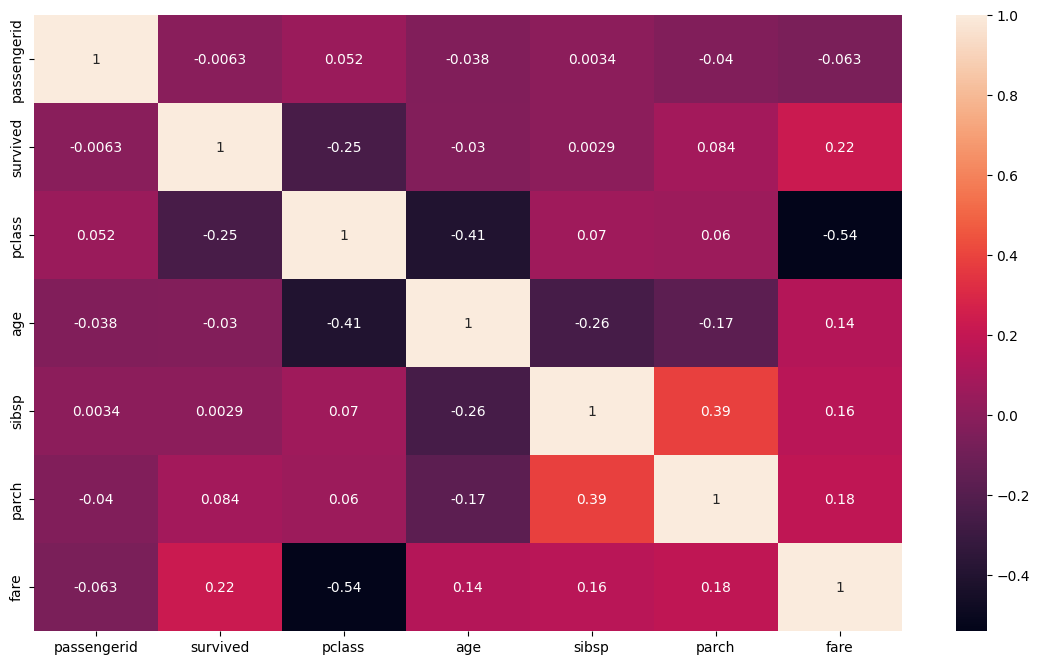

In [11]:
plt.figure(figsize=(14,8))
sns.heatmap(train_df.corr(), annot=True)
plt.show()

In [12]:
train_df['withsomeone'] = train_df.sibsp+train_df.parch

In [13]:
test_df['withsomeon'] = test_df.sibsp+test_df.parch

In [14]:
train_df.drop(['passengerid'], axis=1, inplace=True)
test_df.drop(['passengerid'], axis=1, inplace=True)

In [15]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 916 entries, 0 to 915
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   survived     916 non-null    int64  
 1   pclass       916 non-null    int64  
 2   name         916 non-null    object 
 3   gender       916 non-null    object 
 4   age          736 non-null    float64
 5   sibsp        916 non-null    int64  
 6   parch        916 non-null    int64  
 7   ticket       916 non-null    object 
 8   fare         916 non-null    float64
 9   cabin        198 non-null    object 
 10  embarked     915 non-null    object 
 11  withsomeone  916 non-null    int64  
dtypes: float64(2), int64(5), object(5)
memory usage: 86.0+ KB


In [16]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 393 entries, 0 to 392
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   pclass      393 non-null    int64  
 1   name        393 non-null    object 
 2   gender      393 non-null    object 
 3   age         310 non-null    float64
 4   sibsp       393 non-null    int64  
 5   parch       393 non-null    int64  
 6   ticket      393 non-null    object 
 7   fare        392 non-null    float64
 8   cabin       97 non-null     object 
 9   embarked    392 non-null    object 
 10  withsomeon  393 non-null    int64  
dtypes: float64(2), int64(4), object(5)
memory usage: 33.9+ KB


age 칼럼은 KNN 알고리즘으로 채워준다.

In [17]:
cols = ['age','survived']

### Defining KNN imputer with neighbors
from sklearn.impute import KNNImputer
knn = KNNImputer(n_neighbors=5)

knn.fit_transform(train_df[cols])
#age_mode = train_df.age.value_counts().index[0]

array([[23.1,  0. ],
       [23.1,  0. ],
       [52. ,  1. ],
       ...,
       [19. ,  0. ],
       [25.8,  1. ],
       [53. ,  1. ]])

In [18]:
df2 = pd.DataFrame(knn.transform(train_df[cols]),columns=['Age', 'Survived'])

In [19]:
train_df.age = df2['Age']

In [20]:
age_mode = train_df.age.value_counts().index[0]
test_df.age.fillna(age_mode, inplace=True)

In [132]:
#train_df.age.fillna(age_mode, inplace=True)
#test_df.age.fillna(age_mode, inplace=True)

In [21]:
train_df.isnull().sum()

survived         0
pclass           0
name             0
gender           0
age              0
sibsp            0
parch            0
ticket           0
fare             0
cabin          718
embarked         1
withsomeone      0
dtype: int64

In [24]:
from sklearn.preprocessing import LabelEncoder
train_df['Title'] = train_df.name.str.extract('([A-Za-z]+)\.', expand = False)
test_df['Title'] = test_df.name.str.extract('([A-Za-z]+)\.', expand = False)

#X.Title.value_counts()
# As we can see, Mr, Miss, Mrs, Master

# All rare titles will be aliased as "Rare" in our new column to prevent overfitting
rare_titles = ['Rev','Dr','Major','Col','Capt','Jonkheer','Countess']
train_df.Title = train_df.Title.replace(rare_titles,'Rare')
test_df.Title = test_df.Title.replace(rare_titles,'Rare')

# I will label encode the new feature now in both X and X_test_data
train_df['Title'] = LabelEncoder().fit_transform(train_df['Title']) 
test_df['Title'] = LabelEncoder().fit_transform(test_df['Title'])

In [26]:
test_df

,pclass,name,gender,age,sibsp,parch,ticket,fare,cabin,embarked,withsomeon,Title
0,3,"McGowan, Miss. Anna ""Annie""",female,15.0,0,0,330923,8.0292,NaN,Q,0,3
1,2,"Pinsky, Mrs. (Rosa)",female,32.0,0,0,234604,13.0000,NaN,S,0,7
2,3,"McCarthy, Miss. Catherine Katie""""",female,23.1,0,0,383123,7.7500,NaN,Q,0,3
3,3,"Franklin, Mr. Charles (Charles Fardon)",male,23.1,0,0,SOTON/O.Q. 3101314,7.2500,NaN,S,0,6
4,1,"Wick, Mrs. George Dennick (Mary Hitchcock)",female,45.0,1,1,36928,164.8667,NaN,S,2,7
...,...,...,...,...,...,...,...,...,...,...,...,...
388,3,"Healy, Miss. Hanora ""Nora""",female,23.1,0,0,370375,7.7500,NaN,Q,0,3
389,1,"Hippach, Miss. Jean Gertrude",female,16.0,0,1,111361,57.9792,B18,C,1,3
390,3,"Ayoub, Miss. Banoura",female,13.0,0,0,2687,7.2292,NaN,C,0,3
391,3,"Andersson, Mrs. Anders Johan (Alfrida Konstant...",female,39.0,1,5,347082,31.2750,NaN,S,6,7


In [27]:
emb_mode = train_df.embarked.value_counts().index[0]

In [28]:
train_df.embarked.fillna(emb_mode, inplace=True)
test_df.embarked.fillna(emb_mode, inplace=True)

In [29]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 916 entries, 0 to 915
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   survived     916 non-null    int64  
 1   pclass       916 non-null    int64  
 2   name         916 non-null    object 
 3   gender       916 non-null    object 
 4   age          916 non-null    float64
 5   sibsp        916 non-null    int64  
 6   parch        916 non-null    int64  
 7   ticket       916 non-null    object 
 8   fare         916 non-null    float64
 9   cabin        198 non-null    object 
 10  embarked     916 non-null    object 
 11  withsomeone  916 non-null    int64  
 12  Title        916 non-null    int64  
dtypes: float64(2), int64(6), object(5)
memory usage: 93.2+ KB


In [30]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 393 entries, 0 to 392
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   pclass      393 non-null    int64  
 1   name        393 non-null    object 
 2   gender      393 non-null    object 
 3   age         393 non-null    float64
 4   sibsp       393 non-null    int64  
 5   parch       393 non-null    int64  
 6   ticket      393 non-null    object 
 7   fare        392 non-null    float64
 8   cabin       97 non-null     object 
 9   embarked    393 non-null    object 
 10  withsomeon  393 non-null    int64  
 11  Title       393 non-null    int64  
dtypes: float64(2), int64(5), object(5)
memory usage: 37.0+ KB


get_dummies를 통해 object type을 정수형으로 바꿔준다.

>neumerical data가 필요하다고 해서
female=1, male=2 식으로 정수형으로만 변경하면,
male = female * 2 같은 상관관계가 생겨버린다.
실제로는 이런 관계가 존재하지 않으므로 one-hot encoding을 통해 처리한다.

In [31]:
gender_hot = pd.get_dummies(train_df.gender, drop_first=True)
# drop_first=True 는 첫번째 옵션을 drop함을 뜻합니다.
# 예로 Sex column에서 female이 1이라면, 0인 row는 자동으로 male을 의미하게 됩니다.

train_df = pd.concat([train_df, gender_hot], axis=1)
train_df.drop(['gender'], axis=1, inplace=True)

gender_hot = pd.get_dummies(test_df.gender, drop_first=True)
# drop_first=True 는 첫번째 옵션을 drop함을 뜻합니다.
# 예로 Sex column에서 female이 1이라면, 0인 row는 자동으로 male을 의미하게 됩니다.

test_df = pd.concat([test_df, gender_hot], axis=1)
test_df.drop(['gender'], axis=1, inplace=True)

In [32]:
embarked_hot = pd.get_dummies(train_df.embarked, drop_first=True)

train_df = pd.concat([train_df, embarked_hot], axis=1)
train_df.drop(['embarked'], axis=1, inplace=True)

embarked_hot = pd.get_dummies(test_df.embarked, drop_first=True)
# drop_first=True 는 첫번째 옵션을 drop함을 뜻합니다.
# 예로 Sex column에서 female이 1이라면, 0인 row는 자동으로 male을 의미하게 됩니다.

test_df = pd.concat([test_df, embarked_hot], axis=1)
test_df.drop(['embarked'], axis=1, inplace=True)

In [35]:
train_df

,survived,pclass,name,age,sibsp,parch,ticket,fare,cabin,withsomeone,Title,male,Q,S
0,0,2,"Wheeler, Mr. Edwin Frederick""""",23.1,0,0,SC/PARIS 2159,12.8750,NaN,0,4,1,0,1
1,0,3,"Henry, Miss. Delia",23.1,0,0,382649,7.7500,NaN,0,2,0,1,0
2,1,1,"Hays, Mrs. Charles Melville (Clara Jennings Gr...",52.0,1,1,12749,93.5000,B69,2,5,0,0,1
3,1,3,"Andersson, Mr. August Edvard (""Wennerstrom"")",27.0,0,0,350043,7.7958,NaN,0,4,1,0,1
4,0,2,"Hold, Mr. Stephen",44.0,1,0,26707,26.0000,NaN,1,4,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
911,0,3,"Thomas, Mr. Charles P",23.1,1,0,2621,6.4375,NaN,1,4,1,0,0
912,0,3,"Cacic, Mr. Jego Grga",18.0,0,0,315091,8.6625,NaN,0,4,1,0,1
913,0,2,"Pengelly, Mr. Frederick William",19.0,0,0,28665,10.5000,NaN,0,4,1,0,1
914,1,3,"Mullens, Miss. Katherine ""Katie""",25.8,0,0,35852,7.7333,NaN,0,2,0,1,0


In [36]:
train_df.drop(['name', 'sibsp', 'parch', 'ticket', 'cabin'], axis=1, inplace=True)

In [37]:
test_df.drop(['name', 'sibsp', 'parch', 'ticket', 'cabin'], axis=1, inplace=True)

In [38]:
train_df

,survived,pclass,age,fare,withsomeone,Title,male,Q,S
0,0,2,23.1,12.8750,0,4,1,0,1
1,0,3,23.1,7.7500,0,2,0,1,0
2,1,1,52.0,93.5000,2,5,0,0,1
3,1,3,27.0,7.7958,0,4,1,0,1
4,0,2,44.0,26.0000,1,4,1,0,1
...,...,...,...,...,...,...,...,...,...
911,0,3,23.1,6.4375,1,4,1,0,0
912,0,3,18.0,8.6625,0,4,1,0,1
913,0,2,19.0,10.5000,0,4,1,0,1
914,1,3,25.8,7.7333,0,2,0,1,0


In [39]:
ndptrain_df = train_df.drop_duplicates(keep='first', ignore_index=True)
ndptest_df = test_df.drop_duplicates(keep='first', ignore_index=True)

In [258]:
ndptrain_df = train_df

In [234]:
cortensor = torch.tensor(train_df.values)

In [40]:
ndptrain_df

,survived,pclass,age,fare,withsomeone,Title,male,Q,S
0,0,2,23.1,12.8750,0,4,1,0,1
1,0,3,23.1,7.7500,0,2,0,1,0
2,1,1,52.0,93.5000,2,5,0,0,1
3,1,3,27.0,7.7958,0,4,1,0,1
4,0,2,44.0,26.0000,1,4,1,0,1
...,...,...,...,...,...,...,...,...,...
803,1,3,12.0,11.2417,1,1,1,0,0
804,0,3,23.1,6.4375,1,4,1,0,0
805,0,3,18.0,8.6625,0,4,1,0,1
806,1,3,25.8,7.7333,0,2,0,1,0


# Scalarization

원본 데이터들은 데이터 고유의 특성과 분포가 있습니다.
하지만 이 데이터를 그대로 학습에 사용하면
크게 작용하는 feature와, 거의 영향을 미치지못하는 feature가 생깁니다.
또한 패턴을 찾기 어려워지기때문에 학습이 느려지고 성능이 떨어집니다.
물론 정밀한 data 분석을 통해 어느정도 무게차이를 주는것은 중요하지만,
우선 편의를 위해 StandardScaler를 사용하여 data를 scaling하였습니다.

StandardScaler

- 기존 변수의 범위를 정규 분포로 변환.
- 모든 피처의 평균을 0, 분산을 1로 변환.
- 이상치가 있다면 평균과 표준편차에 영향을 미치기 때문에 데이터의 확산이 달라지게 되므로 이상치가 많을때에는 사용하지 않는게 좋음.


In [41]:
y_train = ndptrain_df.survived.values

In [42]:
#sub_passengerid = test_df['passengerid'].values

Scaler1 = StandardScaler()
Scaler2 = StandardScaler()

train_columns = ndptrain_df.columns
test_columns = test_df.columns

ndptrain_df = pd.DataFrame(Scaler1.fit_transform(ndptrain_df))
test_df = pd.DataFrame(Scaler2.fit_transform(test_df))

In [43]:
ndptrain_df.columns = train_columns
test_df.columns = test_columns

In [44]:
ndptrain_df

,survived,pclass,age,fare,withsomeone,Title,male,Q,S
0,-0.824520,-0.279789,-0.437888,-0.421717,-0.597090,0.260979,0.784857,-0.280663,0.646176
1,-0.824520,0.891556,-0.437888,-0.518439,-0.597090,-1.312686,-1.274118,3.562992,-1.547565
2,1.212826,-1.451135,1.701301,1.099897,0.656024,1.047812,-1.274118,-0.280663,0.646176
3,1.212826,0.891556,-0.149209,-0.517575,-0.597090,0.260979,0.784857,-0.280663,0.646176
4,-0.824520,-0.279789,1.109138,-0.174012,0.029467,0.260979,0.784857,-0.280663,0.646176
...,...,...,...,...,...,...,...,...,...
803,1.212826,0.891556,-1.259515,-0.452541,0.029467,-2.099518,0.784857,-0.280663,-1.547565
804,-0.824520,0.891556,-0.437888,-0.543210,0.029467,0.260979,0.784857,-0.280663,-1.547565
805,-0.824520,0.891556,-0.815392,-0.501218,-0.597090,0.260979,0.784857,-0.280663,0.646176
806,1.212826,0.891556,-0.238033,-0.518755,-0.597090,-1.312686,-1.274118,3.562992,-1.547565


In [45]:
test_df

,pclass,age,fare,withsomeon,Title,male,Q,S
0,0.837163,-1.015267,-0.501760,-0.564291,-1.489209,-1.351791,2.890872,-1.481594
1,-0.359219,0.236216,-0.410574,-0.564291,0.993333,-1.351791,-0.345916,0.674949
2,0.837163,-0.418972,-0.506882,-0.564291,-1.489209,-1.351791,2.890872,-1.481594
3,0.837163,-0.418972,-0.516054,-0.564291,0.372697,0.739759,-0.345916,0.674949
4,-1.555601,1.193231,2.375306,0.664332,0.993333,-1.351791,-0.345916,0.674949
...,...,...,...,...,...,...,...,...
388,0.837163,-0.418972,-0.506882,-0.564291,-1.489209,-1.351791,2.890872,-1.481594
389,-1.555601,-0.941650,0.414535,0.050020,-1.489209,-1.351791,-0.345916,-1.481594
390,0.837163,-1.162500,-0.516436,-0.564291,-1.489209,-1.351791,-0.345916,-1.481594
391,0.837163,0.751532,-0.075333,3.121578,0.993333,-1.351791,-0.345916,0.674949


In [264]:
test_df.drop(['passengerid'])

KeyError: "['passengerid'] not found in axis"

In [46]:
X_train = ndptrain_df.iloc[:,1:].values

In [147]:
X_train.shape

torch.Size([916, 8])

# Modeling

모델은 512개의 뉴런을 갖는 2개의 fc hidden layer와,
마지막으로 2개 뉴런의 output을 갖는 output layer로 구성하였습니다.
각 hidden layer는 activation으로 ReLU를 사용하며,
overfitting을 방지하기 위해 Dropout을 적용합니다.



In [153]:
class Net(nn.Module):
    def __init__(self):
        N=256
        super(Net,self).__init__()
        self.layer1 = nn.Sequential(
        nn.Linear(8, N),
        nn.ReLU(),
        nn.Dropout(0.3))
        self.layer2 = nn.Sequential(
        nn.Linear(N, int(N)),
        nn.ReLU(),
        nn.Dropout(0.3))
        self.layer3 = nn.Linear(int(N), 2)
        
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        return x
        
model = Net()
print(model)

Net(
  (layer1): Sequential(
    (0): Linear(in_features=8, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
  )
  (layer2): Sequential(
    (0): Linear(in_features=256, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
  )
  (layer3): Linear(in_features=256, out_features=2, bias=True)
)


# DataSet & Dataloader

data를 좀 더 쉽게 다룰 수 있도록 Dataset, DataLoader를 사용하였습니다.

X_train, y_train으로 dataset을 만들면
이 dataset으로 dataloader를 사용할 수 있습니다.
minibatch크기는 64로,
그리고 shuffle=True를 해줍니다.

>shuffle=True를 해 준 이유는
각 epoch마다 dataset을 섞어서 data가 학습되는 순서를 바꾸기 위함입니다.
이는 모델이 dataset의 순서에 익숙해지는것을 방지합니다.

또한, DataLoader의 옵션 중 drop_last는 설정하지 않았는데,
학습 data의 수는 891개이고, batch_size는 64이므로
14개의 배치를 갖고, 마지막 배치의 크기는 59이므로 크게 영향이 없다고 판단하였습니다.

In [150]:
from sklearn.model_selection import StratifiedKFold

class StratifiedBatchSampler:
    """Stratified batch sampling
    Provides equal representation of target classes in each batch
    """
    def __init__(self, y, batch_size, shuffle=True):
        if torch.is_tensor(y):
            y = y.numpy()
        assert len(y.shape) == 1, 'label array must be 1D'
        n_batches = int(len(y) / batch_size)
        self.skf = StratifiedKFold(n_splits=n_batches, shuffle=shuffle)
        self.X = torch.randn(len(y),1).numpy()
        self.y = y
        self.shuffle = shuffle

    def __iter__(self):
        if self.shuffle:
            self.skf.random_state = torch.randint(0,int(1e8),size=()).item()
        for train_idx, test_idx in self.skf.split(self.X, self.y):
            yield test_idx

    def __len__(self):
        return len(self.y)

In [123]:
train = pd.read_csv('data/eda_ext_train.csv')
test = pd.read_csv('data/eda_ext_test.csv')

In [127]:
train.drop(['passengerid'], axis=1, inplace=True)
test.drop(['passengerid'], axis=1, inplace=True)

In [129]:
y_train = train.survived.values

In [130]:
X_train = train.drop(['survived'], axis=1).values

In [145]:
X_train.shape

torch.Size([916, 8])

In [140]:
#stratification 적용해보기, batch size 바꿔보기
X_train = torch.FloatTensor(X_train)
y_train = torch.FloatTensor(y_train)

#dataset = TensorDataset(X_train, y_train)
#dataloader = StratifiedSampler(dataset, batch_size=64)
dataloader = DataLoader(
    dataset=TensorDataset(X_train,y_train),
    batch_sampler=StratifiedBatchSampler(y_train, batch_size=128)
)

In [139]:
dataloader

In [146]:
y_train.shape

torch.Size([916])

# loss functoin & optimizer
loss function은 CrossEntropyLoss를 사용합니다.
이때, torch에서 제공하는 CrossEntropyLoss함수는 softmax함수를 포함합니다.
따라서 model의 마지막 layer가 softmax일 필요는 없습니다.

optimizer로는 Adam을 사용합니다.
learning rate은 0.01로 설정하였습니다.

In [151]:
criterion = nn.CrossEntropyLoss()
#criterion = nn.HingeEmbeddingLoss

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Training
총 epoch는 2000회를 거치고,
loss가 minimum값을 가질때마다 그때의 state를 저장합니다.

In [108]:
model

Net(
  (layer1): Sequential(
    (0): Linear(in_features=8, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
  )
  (layer2): Sequential(
    (0): Linear(in_features=256, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
  )
  (layer3): Linear(in_features=256, out_features=2, bias=True)
)

In [113]:
X_test = torch.FloatTensor(test_df.values)
with torch.no_grad():
    result = model(X_test)
labels = torch.argmax(result, dim=1)
survived = labels.numpy()

In [114]:
import gc
gc.collect()

8

In [115]:
test_df2 = pd.read_csv('data/test.csv')
sub_passengerid = test_df2['passengerid'].values

In [116]:
submission = pd.DataFrame({'passengerid': sub_passengerid, 'Survived': survived})
submission.to_csv('data/submission.csv', index=False)

In [94]:
sub_passengerid

array([ 916,  917,  918,  919,  920,  921,  922,  923,  924,  925,  926,
        927,  928,  929,  930,  931,  932,  933,  934,  935,  936,  937,
        938,  939,  940,  941,  942,  943,  944,  945,  946,  947,  948,
        949,  950,  951,  952,  953,  954,  955,  956,  957,  958,  959,
        960,  961,  962,  963,  964,  965,  966,  967,  968,  969,  970,
        971,  972,  973,  974,  975,  976,  977,  978,  979,  980,  981,
        982,  983,  984,  985,  986,  987,  988,  989,  990,  991,  992,
        993,  994,  995,  996,  997,  998,  999, 1000, 1001, 1002, 1003,
       1004, 1005, 1006, 1007, 1008, 1009, 1010, 1011, 1012, 1013, 1014,
       1015, 1016, 1017, 1018, 1019, 1020, 1021, 1022, 1023, 1024, 1025,
       1026, 1027, 1028, 1029, 1030, 1031, 1032, 1033, 1034, 1035, 1036,
       1037, 1038, 1039, 1040, 1041, 1042, 1043, 1044, 1045, 1046, 1047,
       1048, 1049, 1050, 1051, 1052, 1053, 1054, 1055, 1056, 1057, 1058,
       1059, 1060, 1061, 1062, 1063, 1064, 1065, 10